In [ ]:
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras import backend as K
import seaborn as sns

In [ ]:
!wget -O aclImdbGen.tar.gz https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
#!tar -xf aclImdb_v1.tar.gz

In [2]:
dataset_train = keras.utils.text_dataset_from_directory(
    directory="aclImdb/train", label_mode=None, batch_size=256
)
dataset_train = dataset_train.map(lambda x: tf.strings.regex_replace(x, "<br />", " "))

Found 20003 files belonging to 1 classes.


In [ ]:
sequence_length = 100
vocab_size = 15000
text_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
text_vectorization.adapt(dataset_train)

In [4]:
def prepare_lm_dataset(text_batch):
    vectorized_sequences = text_vectorization(text_batch)
    x = vectorized_sequences[:, :-1]
    y = vectorized_sequences[:, 1:]
    return x, y

lm_dataset_train = dataset_train.map(prepare_lm_dataset, num_parallel_calls=4)

In [4]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [3]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
            layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
             [tf.expand_dims(batch_size, -1),
              tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

In [7]:
embed_dim = 256
latent_dim = 2048
num_heads = 2

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")

In [8]:
model.fit(lm_dataset_train, epochs=20)

Epoch 20/20
79/79 [==============================] - 245s 3s/step - loss: 3.1298


In [9]:
model.save("text-generation/transformer_best.keras")
model.save_weights("ext-generation/transformer_best_weights")

In [5]:
model = keras.models.load_model(
    "text-generation/transformer_best.keras",
    custom_objects={"TransformerDecoder": TransformerDecoder,
                    "PositionalEmbedding": PositionalEmbedding})

<AxesSubplot:ylabel='Frequency'>

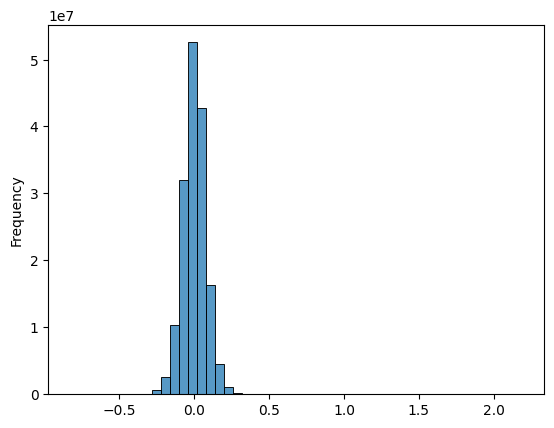

In [5]:
weights = model.get_weights()
flattened_weights = [w.flatten() for w in weights]
weights_array = [item for sublist in flattened_weights for item in sublist]
sns.histplot(weights_array, stat='frequency', bins=50)

In [57]:
sentence = "This"
generate_length = 16

tokens_index = dict(enumerate(text_vectorization.get_vocabulary())) 

def sample_next(predictions, temperature=0.8): 
 predictions = np.asarray(predictions).astype("float64")
 predictions = np.log(predictions) / temperature
 exp_preds = np.exp(predictions)
 predictions = exp_preds / np.sum(exp_preds)
 probas = np.random.multinomial(1, predictions, 1)
 return np.argmax(probas)

for i in range(generate_length):
 tokenized_sentence = text_vectorization([sentence]) 
 predictions = model(tokenized_sentence) 
 next_token = sample_next(predictions[0, i, :]) 
 sampled_token = tokens_index[next_token] 
 sentence += " " + sampled_token 

print(sentence)

This movie was extremely boring and [UNK] it was just too long to see the actual series


Evaluate the model converting the weights to Posit<16,0>

In [6]:
K.set_floatx('posit160')

# Get the original weights
ws = model.get_weights()
print(np.unique([w.dtype for w in model.get_weights()]))

[dtype('float32')]


In [8]:
# Convert the weights to Posit <16,0> and load a new model
wsp = [w.astype(K.floatx()) for w in ws]

inputs = keras.Input(shape=(None,), dtype="int64")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model_posit = keras.Model(inputs, outputs)
model_posit.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
model_posit.set_weights(wsp)

print(np.unique([w.dtype for w in model_posit.get_weights()]))

[dtype(posit160)]


In [47]:
for i in range(generate_length):
 tokenized_sentence = text_vectorization([sentence]) 
 predictions = model(tokenized_sentence) 
 next_token = sample_next(predictions[0, i, :]) 
 sampled_token = tokens_index[next_token] 
 sentence += " " + sampled_token 

print(sentence)

This film was a disappointment i did not recommend it to anyone who likes michael caine wishes
